# **Image Classification with Convolutional Neural Networks (CNNs)**

Convolutional neural networks (CNNs) are commonly used in data science domain especially for computer vision and image classification tasks. Consider an image classification task. Images consist of pixels which are represented with numbers. In the convolution layer of CNNs, filters (or feature detectors) are applied to the image to extract distinctive features of the image by preserving the spatial relationships among pixels.

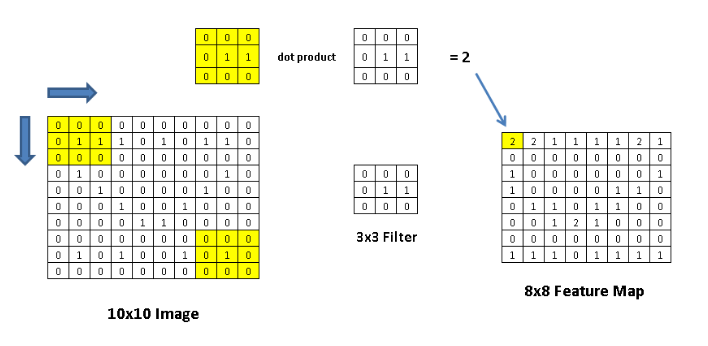

In a convolution layer, not just one filter is used. Many different filters are applied to the image. Each filter is aimed to capture a different feature such as edges, horizontol lines and so on.

Images are highly non-linear so we need to increase the non-linearity in convolution layer. In the convolution layer, rectifier function is applied to increase the non-linearity in the image. Rectifier function acts as an additional filter to break up linearity.

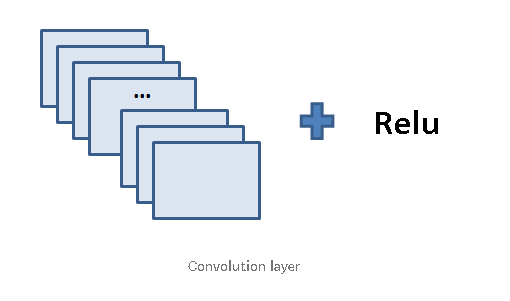

Then we have Pooling layer which reduces the size of the feature maps while maintaining the preserved features of the image.

In the pooling layer, a box with a specified size is captured and the maximum value in that box is taken. This is maximum pooling. We can also take the sum or mean of values in the box. This box scans through the entire feature map. 

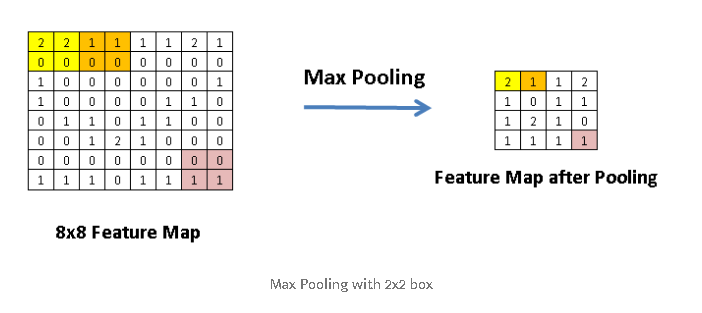

The advantages of pooling:


*   Reducing the size while preserving the features
*   Eliminating parts that are not significant
*   Introducing spatial variance
*   Reducing the number of features and thus reducing the risk of overfitting

Now, we need to flatten pooled feature maps in order to feed them to a fully connected layer. After the flattening step, the structure of the remaining part of a convolutional neural network is just like a feed-forward neural network.

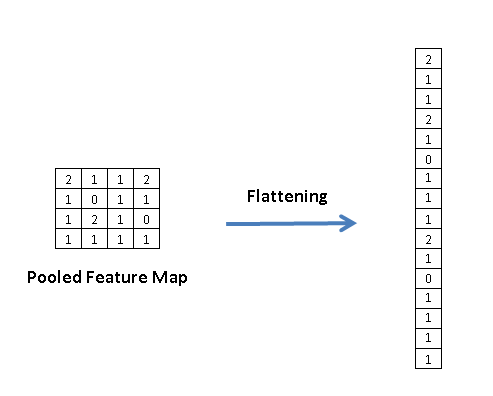

The resulting array after flattening is used as the input to a Dense layer. The pooled feature maps are flattened and fed through a dense layer.

Let's go through an implementation with Keras.





# **Building a Convolutional Neural Network with Keras**

**Import Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
tf.__version__

import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
import imageio

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

'2.8.2'

In [ ]:
#RAR LIBRARY INSTALLATION
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 1.1 MB/s 


In [ ]:
#DATASET EXTRACTION
import patoolib
patoolib.extract_archive("/content/dataset-colab-25.rar", outdir="/content/")

patool: Extracting /content/dataset-colab-25.rar ...
patool: running /usr/bin/unrar x -- /content/dataset-colab-25.rar
patool:     with cwd='/content/'
patool: ... /content/dataset-colab-25.rar extracted to `/content/'.


'/content/'

**ImageDataGenerator**

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. ImageDataGenerator creates many batches of the images by applying random selections and transformations (such as rotating and shifting) in batches. So it increases the diversity of the dataset. Data augmentation increases the diversity of data which is very useful especially when the number of images is limited. Increasing the diversity of the dataset helps to get more accurate results and also prevents the model from overfitting.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) #Normalize the pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#File path to the folder containin images
train_dir = os.path.join('/content/dataset-colab-25/Train')
validation_dir = os.path.join('/content/dataset-colab-25/Validation')

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64,64),
    batch_size=256,
    shuffle=True,
    class_mode='binary')

Found 33128 images belonging to 2 classes.
Found 6780 images belonging to 2 classes.


**Building the Model**

In [ ]:
model = tf.keras.models.Sequential([
                                    
    # First convolution layer 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3),use_bias=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Second convolution layer 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    

    # Third convolution layer  
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

  # Fourth convolution layer  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),


    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    # Fully connected hidden layer
    tf.keras.layers.Dense(8, activation='relu',use_bias=True),


    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid',activity_regularizer=regularizers.L1(0.001))   

])


**Model Summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       2

**Optimizer Implementation and model training/validation**

In [ ]:
#from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5)])  

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99): 
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ECG_Spectrogram_Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(
      train_generator,
      steps_per_epoch=10, 
      epochs=500,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=5,
      callbacks = [callbacks,checkpoint]
) 

Epoch 1/500
10/10 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5410 - sensitivity_at_specificity: 0.5884 - specificity_at_sensitivity: 0.5521 - recall: 0.3702 - precision: 0.5477
Epoch 1: val_accuracy improved from -inf to 0.65312, saving model to ECG_Spectrogram_Model.h5
10/10 [==============================] - 17s 241ms/step - loss: 0.6867 - accuracy: 0.5410 - sensitivity_at_specificity: 0.5884 - specificity_at_sensitivity: 0.5521 - recall: 0.3702 - precision: 0.5477 - val_loss: 0.6646 - val_accuracy: 0.6531 - val_sensitivity_at_specificity: 0.7738 - val_specificity_at_sensitivity: 0.7083 - val_recall: 0.7934 - val_precision: 0.6315
Epoch 2/500
10/10 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.7488 - sensitivity_at_specificity: 0.9753 - specificity_at_sensitivity: 0.8246 - recall: 0.7975 - precision: 0.7304
Epoch 2: val_accuracy improved from 0.65312 to 0.67344, saving model to ECG_Spectrogram_Model.h5
10/10 [====================

**Performance Metrics**

In [ ]:
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity']
Validation_Recall=history.history['val_recall']
Validation_Precision=history.history['val_precision']
Validation_Loss=history.history['val_loss']

print("Training Accuracy: ",max(Training_Accuracy))
print("Validation Accuracy: ",max(Validation_Accuracy))
print("Validation Specificity: ",max(Validation_Specificity))
print("Validation Sensitivity: ",max(Validation_Sensitivity))
print("Validation Recall: ",max(Validation_Recall))
print("Validation Precision: ",max(Validation_Precision))
print("Validation Loss: ",min(Validation_Loss))

Training Accuracy:  0.9921875
Validation Accuracy:  0.69140625
Validation Specificity:  0.8009259104728699
Validation Sensitivity:  0.8874074220657349
Validation Recall:  1.0
Validation Precision:  0.63671875
Validation Loss:  0.5633885860443115


**Accuracy Graph**

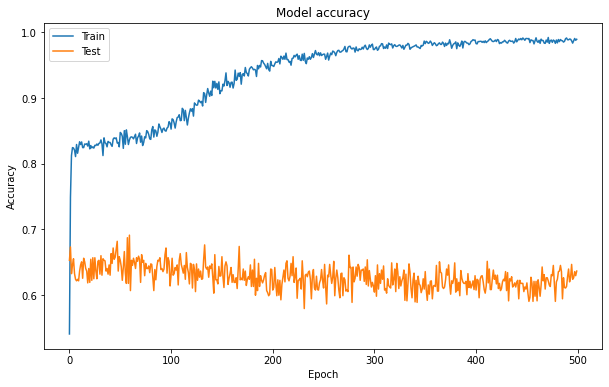

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Loss Graph**

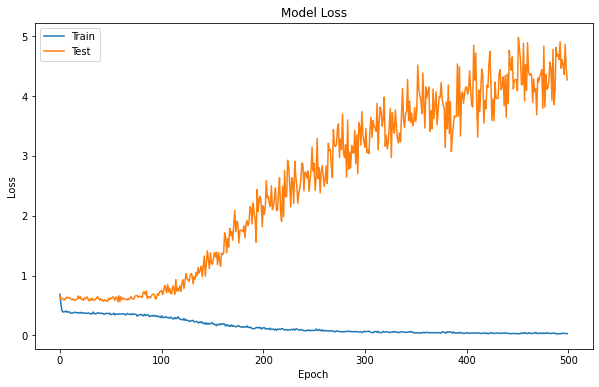

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()